In [1]:
import torch as t
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import pygame

pygame 2.1.2 (SDL 2.0.16, Python 3.10.5)
Hello from the pygame community. https://www.pygame.org/contribute.html


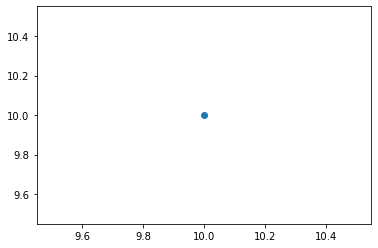

In [2]:
pos_x = t.tensor([[10]]).cuda()
pos_y = t.tensor([[10]]).cuda()
plt.scatter(pos_x.cpu().numpy(), pos_y.cpu().numpy())

In [3]:
# DIM = 3
# CARRIERS = 9
NUM_AGENTS = 64
NUM_STATES = 3
NUM_PERCEPTIONS = 3
NUM_ACTIONS = 512
NUM_THINGS = 3
# Model testing
MULT = 2
RES = 512

def rotate(x, angle): 
    ca = t.cos(angle)
    sa = t.sin(angle)
    
    return t.cat([ca*x[:,:,:,0:1]+sa*x[:,:,:,1:2], -sa*x[:,:,:,0:1]+ca*x[:,:,:,1:2]], 3)

def sigmoid(x):
    return 1/(1+np.exp(-0.25 * x))

# dim 3 carries the x,y variation
def mirror(p):
    p = RES-1-p
    w1 = t.le(p,0).long()
    p = (1-w1)*p + w1*(-p)

    p = RES-1-p
    w1 = t.le(p,0).long()
    p = (1-w1)*p + w1*(-p)
    
    return p

class RadConv(nn.Module):
    def __init__(self, NI, radius):
        super().__init__()
        self.conv = nn.Conv2d(NI, NI, 2*radius+1, padding=radius, padding_mode='circular', bias=None)
        
        avg_weight = t.zeros_like(self.conv.weight.data)
        
        for theta in np.arange(0,2*np.pi,np.pi/256.0):
            avg_weight += rotate(self.conv.weight.data.detach().clone(), 180*theta/np.pi)/128.0
        
        avg_weight /= avg_weight.sum(3).sum(2).unsqueeze(2).unsqueeze(3)
        
        self.conv.weight.data = avg_weight
        for i in range(NI):
            for j in range(i):
                self.conv.weight.data[i,j] = 0
                self.conv.weight.data[j,i] = 0
    
    def forward(self, x):
        return self.conv(x)

In [4]:
t.tensor(np.arange(0,2*np.pi,np.pi/256.0)).cuda().shape

torch.Size([512])

In [5]:
directions = t.tensor([theta for theta in np.arange(0,2*np.pi,np.pi/256.0)]).cuda().view(NUM_ACTIONS, 1); print(directions.shape)
num_directions = directions.shape[0]; print(num_directions)
speeds = t.tensor([speed for speed in t.rand(num_directions)]).cuda().view(NUM_ACTIONS, 1); print(speeds.shape)
actions = t.cat([speeds, directions], 1); print(actions.shape)

torch.Size([512, 1])
512
torch.Size([512, 1])
torch.Size([512, 2])


In [6]:
positions = t.rand(NUM_AGENTS, 2).cuda(); print(positions.shape)

torch.Size([64, 2])


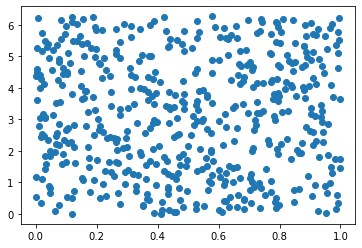

In [7]:
plt.scatter(actions.cpu().numpy()[:, 0], actions.cpu().numpy()[:, 1])

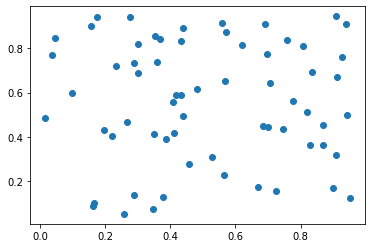

In [8]:
plt.scatter(positions.cpu().numpy()[:, 0], positions.cpu().numpy()[:, 1])

In [9]:

radius = 5

class Agents(nn.Module):
    def __init__(self, 
                    positions, 
                    actions, 
                    states = t.rand(NUM_AGENTS, NUM_STATES), 
                    perceptions = t.rand(NUM_AGENTS, NUM_PERCEPTIONS), 
                    things = t.rand(NUM_THINGS)
                    ):
        super(Agents, self).__init__()
        self.position = positions
        self.actions = actions
        self.state = states
        self.perceptions = perceptions
        # self.percepts = RadConv(NUM_AGENTS*NUM_PERCEPTIONS*NUM_STATES*NUM_THINGS*2.0, 9) #things in the environment; other agents states, their perceptions etc; NUM_AGENTS x NUM_STATES x NUM_PERCEPTIONS
        self.conv = nn.Conv2d(NUM_AGENTS*NUM_PERCEPTIONS*NUM_STATES*NUM_THINGS*2, NUM_AGENTS*NUM_PERCEPTIONS*NUM_STATES, 
                                2*radius+1, padding=radius, padding_mode='circular', bias=None)
        self.fc1 = nn.Linear(NUM_AGENTS*NUM_PERCEPTIONS*NUM_STATES, NUM_AGENTS*NUM_PERCEPTIONS*NUM_STATES)
        self.fc2 = nn.Linear(NUM_AGENTS*NUM_PERCEPTIONS*NUM_STATES, NUM_AGENTS*NUM_PERCEPTIONS)
        self.fc3 = nn.Linear(NUM_AGENTS*NUM_PERCEPTIONS*NUM_STATES, NUM_AGENTS*NUM_STATES)
        self.fc4 = nn.Linear(NUM_AGENTS*NUM_PERCEPTIONS*NUM_STATES, NUM_AGENTS*NUM_ACTIONS)
        
    def forward(self, x):
        x = F.relu(self.fc1(x))
        self.perceptions = F.softmin(self.fc2(x).view(NUM_AGENTS, NUM_PERCEPTIONS), dim=1)
        self.states = F.softmax(self.fc3(x).view(NUM_AGENTS, NUM_STATES), dim=1)
        self.actions = F.softmax(self.fc4(x).view(NUM_AGENTS, NUM_ACTIONS), dim=1)
        return t.cat([self.perceptions, self.states, self.actions], 1)

In [10]:
agents = Agents(positions, actions).cuda()

In [11]:
agents.state.shape, agents.perceptions.shape, agents.actions.shape

(torch.Size([64, 3]), torch.Size([64, 3]), torch.Size([512, 2]))

In [12]:
class Environment(nn.Module):
    def __init__(self, spatial_contents, env_state, agents):
        super(Environment, self).__init__()
        self.spatial_contents = spatial_contents
        self.state = env_state
        self.agents = agents
        # self.fc1 = nn.Linear(state, 128)
        # self.fc2 = nn.Linear(128, 128)
        # self.fc3 = nn.Linear(128, contents)

    def forward(self, x):
        # x = F.relu(self.fc1(x))
        # x = F.relu(self.fc2(x))
        # x = self.fc3(x)
        return x

TypeError: empty(): argument 'size' must be tuple of ints, but found element of type float at pos 2

In [ ]:
pygame.init()
screen = pygame.display.set_mode((MULT*RES,MULT*RES), 0, 24)
